# Introduction
This notebook contains all the code used by LabV2 in order to predict ChatGPT's success in solving mathematical word problems.

In [73]:
# Load in our libraries
import os
import shutil
import pandas as pd
import numpy as np
import re
import sklearn
import torch
import torch.nn as nn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier                         
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.utils import shuffle

from sklearn.pipeline import Pipeline

Below, we define various constants that modify various aspects of what the program will do

In [74]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

JSON_OUTPUT_FILE_PATH = '../output/json/'
XLSX_OUTPUT_FILE_PATH = '../output/xlsx/'

# These values need to be provided, it's the location of the files containing the math problems as well as chatgpt's performance on particular problems
MATH_PROBLEMS_INPUT_FILE_PATH = '../data/draw.json'
CHATGPT_INPUT_FILE_PATH = '../data/chatgpt_plus_results_feb.json'

EXTRACTED_FEATURES_FILE_PATH = JSON_OUTPUT_FILE_PATH + '1) extracted_features.json'
COMBINED_FILE_PATH = JSON_OUTPUT_FILE_PATH + "2) combined.json"
CHATGPT_STATS_FILE_PATH = JSON_OUTPUT_FILE_PATH + "3) chatgpt_stats.json"
CAUSALITY_FILE_PATH = JSON_OUTPUT_FILE_PATH + "4) causality_values.json"
SPLIT_DATASET_FILE_PATH = JSON_OUTPUT_FILE_PATH + "5) split_dataset.json"
OOF_FILE_PATH = JSON_OUTPUT_FILE_PATH + "oof/"

# These are the columns the program will extract mathematical features from.
# FORMAT: You can list multiple columns by separating the names with a comma
COLUMNS_WITH_EQUATIONS = "lEquations,Template"

# When generating the geq columns, this constant will define the number of geq columns generated for each math feature
NUM_OF_SYMBOL_MAX_VALUE = 10

EFFECT_COLUMN = "is_correct"
VALID_COLUMN = "valid"

SEED = 64

# These are just constants which define what sort of values we're looking for and the column which indicates whether a row is valid
EFFECT_COLUMN = "is_correct"
VALID_COLUMN = "valid"
COLUMN_TO_CHECK = "result"
OTHER_COLUMN = "final_answer"

QUESTION_NO = 'question_No'

# Some string consts so the column names can be modified a bit easier
NUM_OF_ADDITION_SUFFIX = "_num_of_addition"
NUM_OF_SUBTRACTION_SUFFIX = "_num_of_subtraction"
NUM_OF_ADDITION_AND_SUBTRACTION_SUFFIX = "_num_of_addition_and_subtraction"
NUM_OF_MULTIPLICATION_SUFFIX = "_num_of_multiplication"
NUM_OF_DIVISION_SUFFIX = "_num_of_division"
NUM_OF_MULTIPLICATION_AND_DIVISION_SUFFIX = "_num_of_multiplication_and_division"
NUM_OF_UNKNOWNS_SUFFIX = "_num_of_unknowns"
NUM_OF_EQUATIONS_SUFFIX = "_num_of_equations"
PAIRS_OF_PARENS_SUFFIX = "_pairs_of_parens"

MAX_NAME_DIFFERENCE = 5

# Various constants with text defined by Abhinav
# These constants are here so that, if Abhinav changes his mind on what the strings will look like, the information is centralized and it can be changed in one place
ALL_ANSWERS = "has all the answers"
ALL_ANSWERS_ROUNDED = "has all the answers when rounded"
SOME_SOLUTION = "has one or more of the answers, but not all of them"
SOME_SOLUTION_ROUNDED = "has one or more of the answers when rounded, but not all of them"
NO_SOLUTION = "says no solution"
INVALID = "invalid"

CURR_FILE_PATH = COMBINED_FILE_PATH

torch.manual_seed(SEED)

In these experiments, there are various definitions of whether or not ChatGPT is correct.
They are all collected here to make it easy to make changes

In [75]:
def is_valid(row):
    if row[COLUMN_TO_CHECK] in [INVALID]: return 0
    return 1

    """"""
def column_check(correct_solutions, row):
    if row[COLUMN_TO_CHECK] in correct_solutions: return 0
    else: return 1

    """"""
def not_somewhat_or_fully_correct(row):
    return column_check([ALL_ANSWERS, ALL_ANSWERS_ROUNDED, SOME_SOLUTION, SOME_SOLUTION_ROUNDED], row)
    
    """"""
def not_fully_correct(row):
    return column_check([ALL_ANSWERS, ALL_ANSWERS_ROUNDED], row)

    """"""

correct = not_fully_correct

Below, I define various utility functions just to make it easier to save json, csv and xlsx files and partition them into their respective folders

In [76]:
def save_json(data, name):
    data.to_json(f"{JSON_OUTPUT_FILE_PATH}{name}.json", orient='records')

def save_xlsx(data, name):
    data.to_excel(f"{XLSX_OUTPUT_FILE_PATH}{name}.xlsx")

if os.path.exists(JSON_OUTPUT_FILE_PATH):
        shutil.rmtree(JSON_OUTPUT_FILE_PATH)
os.makedirs(JSON_OUTPUT_FILE_PATH)

## Feature exploration, engineering and cleaning

### Feature engineering  

We first extract various mathematical features from the existing math word problem data set such as number of additions, subtractions, etc
For example, if the question had the following equations: 
```
[
    "x-3=y+3", 
    "3*x = 5*y"
]
```

we will extract the following mathematical features:
- Number of additions and subtractions: 2
- Number of multiplications and divisions = 2
- Number of equations = 2
- Number of unknowns = 2

In [77]:
def num_of_symbol(equations, symbol):
    # Calculates the number of '+' symbols in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    # INPUT: [symbol] should be a character.
    count = 0
    for equation in equations:
        count += equation.count(symbol)
    return count

    """"""
def num_of_addition(equations):
    # Calculates the number of '+' symbols in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    return num_of_symbol(equations, '+')
    
    """"""

def pairs_of_parens(equations):
    # Calculates the number of '+' symbols in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    return num_of_symbol(equations, '(')
    
    """"""
def num_of_subtraction(equations): 
    # Calculates the number of '-' symbols in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    return num_of_symbol(equations, '-')

    """"""
def num_of_multiplication(equations):
    # Calculates the number of '*' symbols in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    return num_of_symbol(equations, '*')

    """"""
def num_of_division(equations):
    # Calculates the number of '/' symbols in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    return num_of_symbol(equations, '/')

    """"""
def num_of_equations(equations):
    # Calculates the number of equations in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    return len(equations)

    """"""
def is_unknown(x):
    return x.isnumeric() == False

    """"""
def is_not_empty(x):
    return len(x) > 0

    """"""
def num_of_unknowns(equations):
    # Calculates the number of equations in [equations]
    # INPUT: [equations] should be an array of strings which represent equations
    # print(str(equations))
    count = 0
    all_unknowns = []
    for equation in equations:
        unknowns = re.split(r'[+-/*()=]+', equation)
        unknowns = [s.strip() for s in unknowns]
        unknowns = list(filter(is_unknown, unknowns))
        unknowns = list(filter(is_not_empty, unknowns))
        all_unknowns.extend(unknowns)

    all_unknowns = np.unique(all_unknowns)
    return len(all_unknowns)
    
    """"""
def generate_geq_columns(data, column, max_value):
    # Generates greater than or equal binary columns of a mathematical feature.
    # Once we calculate the number (amount) of each mathematical feature, 
    # we generate columns of 0s and 1s representing whether the equations have greater than or equal
    # number of a particular feature
    for value in range(1, max_value + 1):
        data[column + "_geq_" + str(value)] = generate_geq_column(data, column, value)
    return data

    """"""
def generate_geq_column(data, column, value):
    # Generates a column of 0s and 1s which represents whether or not the rows in data[column] are >= value. 1 means True and 0 means False 
    return data.apply(lambda row : 1 if row[column] >= value else 0, axis=1)
    
    """"""

In [78]:
def extract_features(input_file_path, output_file_path):
    # Load in the math problem data set
    data = pd.read_json(input_file_path)

    # Calculate the number (amount) of each particular mathematical features
    # We calculate the number of additions (+), subtractions (-), multiplications (*), divisions (*) and equations.
    output_data = pd.DataFrame()
    columns_with_equations = COLUMNS_WITH_EQUATIONS.split(',')
    for column in columns_with_equations:
        output_data[column + NUM_OF_ADDITION_SUFFIX] = data.apply(lambda row : num_of_addition(row[column]), axis=1)
        output_data[column + NUM_OF_SUBTRACTION_SUFFIX] = data.apply(lambda row : num_of_subtraction(row[column]), axis=1)
        output_data[column + NUM_OF_MULTIPLICATION_SUFFIX] = data.apply(lambda row : num_of_multiplication(row[column]), axis=1)
        output_data[column + NUM_OF_DIVISION_SUFFIX] = data.apply(lambda row : num_of_division(row[column]), axis=1)
        output_data[column + NUM_OF_EQUATIONS_SUFFIX] = data.apply(lambda row : num_of_equations(row[column]), axis=1)
        output_data[column + NUM_OF_UNKNOWNS_SUFFIX] = data.apply(lambda row : num_of_unknowns(row[column]), axis=1)
        output_data[column + PAIRS_OF_PARENS_SUFFIX] = data.apply(lambda row : num_of_unknowns(row[column]), axis=1)
        
        output_data[column + NUM_OF_ADDITION_AND_SUBTRACTION_SUFFIX] = output_data[column + NUM_OF_ADDITION_SUFFIX] + output_data[column + NUM_OF_SUBTRACTION_SUFFIX]
        output_data[column + NUM_OF_MULTIPLICATION_AND_DIVISION_SUFFIX] = output_data[column + NUM_OF_MULTIPLICATION_SUFFIX] + output_data[column + NUM_OF_DIVISION_SUFFIX]
        
        output_data = output_data.drop(columns=[column + NUM_OF_ADDITION_SUFFIX,column + NUM_OF_SUBTRACTION_SUFFIX, column + NUM_OF_MULTIPLICATION_SUFFIX, column + NUM_OF_DIVISION_SUFFIX])

        # output_data = generate_geq_columns(output_data, column + NUM_OF_ADDITION_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        # output_data = generate_geq_columns(output_data, column + NUM_OF_SUBTRACTION_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        # output_data = generate_geq_columns(output_data, column + NUM_OF_MULTIPLICATION_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        # output_data = generate_geq_columns(output_data, column + NUM_OF_DIVISION_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        
        output_data = generate_geq_columns(output_data, column + NUM_OF_EQUATIONS_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        output_data = generate_geq_columns(output_data, column + PAIRS_OF_PARENS_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        output_data = generate_geq_columns(output_data, column + NUM_OF_ADDITION_AND_SUBTRACTION_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        output_data = generate_geq_columns(output_data, column + NUM_OF_MULTIPLICATION_AND_DIVISION_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        output_data = generate_geq_columns(output_data, column + NUM_OF_UNKNOWNS_SUFFIX, NUM_OF_SYMBOL_MAX_VALUE)
        
    # Save data to output file
    output_data.to_json(output_file_path, orient='records')


    """"""
extract_features(MATH_PROBLEMS_INPUT_FILE_PATH, EXTRACTED_FEATURES_FILE_PATH)

### Combine ChatGPT response with extracted mathematical features

In [79]:
def negation(column):
    # negation -- 
    # OUTPUT: returns a column of 0s and 1s of the negation of [column]. 1s are flipped to 0 and vice versa
    # INPUT: [column] should be a column of 0s and 1s
    return 1 - column
    
    """"""
def conjunction(column_1, column_2):
    # conjunction -- 
    # output: returns a column of 0s and 1s of the conjunction between [column_1] and [column_2].
    # INPUT: [column_1] and [column_2] should be columns of 0s and 1s
    return column_1 & column_2
    
    """"""
def disjunction(column_1, column_2):
    # disjunction -- 
    # OUTPUT: returns a column of 0s and 1s of the disjunction between [column_1] and [column_2].
    # INPUT: [column_1] and [column_2] should be columns of 0s and 1s
    return column_1 | column_2
    
    """"""
def conditional_probability(occurence_column, condition_column):
    # conditional_probability -- 
    # OUTPUT: returns a number which represents the conditional probability p(occurence | condition)
    # INPUT: [occurence_column] and [condition_column] should be columns of 0s and 1s
    if condition_column.sum() == 0: return 0
    return conjunction(occurence_column, condition_column).sum() / condition_column.sum()
    
    """"""
def prior(data):
    # prior -- 
    # OUTPUT: returns a number which represents the prior
    # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN] and [VALID_COLUMN].
    # TODO : Possible optimizations can be made where we cache the result instead of calling this expensive operation again and again
    return conditional_probability(data[EFFECT_COLUMN], data[VALID_COLUMN])
    
    """"""
def is_prima_facie(data, column_name):
    # is_prima_facie -- 
    # OUTPUT: returns a boolean which determines whether the column indicated by [column_name] is a prima facie
    # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN] and [VALID_COLUMN].
    # INPUT: [column_name] should be a valid column in [data]
    # INPUT: The [CORRECT_COLUMN] and [VALID_COLUMN] columns should be columns of 0s and 1s 
    return conditional_probability(data[EFFECT_COLUMN], data[column_name]) > prior(data)
    
    """"""
def is_cooccur(column_1, column_2):
    # is_cooccur -- 
    # OUTPUT: returns a boolean based on if there is at least one row where both [column_1] and [column_2] is equal to 1
    # INPUT: [column_1] and [column_2] should both be columns of 0s and 1s
    return conjunction(column_1, column_2).sum() > 0
    
    """"""
def is_same_category(column_name_1, column_name_2):
    # same_category -- 
    # OUTPUT: Returns a boolean signifying whether the [column_name_1] and [column_name_2] are different by [MAX_NAME_DIFFERENCE]
    #         If the two words are not different by [MAX_NAME_DIFFERENCE], they are in the same category so it returns true
    count = 0
    shortest = min(len(column_name_1), len(column_name_2))
    for i in range(0, shortest):
        if column_name_1[i] == column_name_2[i]:
            count = count + 1
    return max(len(column_name_1), len(column_name_2)) - count < MAX_NAME_DIFFERENCE
    
    """"""
def rel(data, column_name):
    # rel -- 
    # OUTPUT: returns a list of the names of other columns which cooccur with [column_name] and are prima facie
    # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN] and [VALID_COLUMN].
    # INPUT: [column_name] should be a valid column in [data]
    # INPUT: The [CORRECT_COLUMN] and [VALID_COLUMN] columns should be columns of 0s and 1s 
    
    # # If it is not a prima facie cause, we don't bother to find its rel
    if not is_prima_facie(data,column_name): return[]
    
    if prior(data) >= conditional_probability(data[EFFECT_COLUMN], data[column_name]):
        return []
        
    if column_name in [VALID_COLUMN, EFFECT_COLUMN]: return []
    
    name_list = []
    for potential_cause in data.columns:
        # Make sure we are not including the [CORRECT_COLUMN] and [VALID_COLUMN] as part of rel
        if potential_cause in [EFFECT_COLUMN, VALID_COLUMN, column_name]: continue

        if is_same_category(potential_cause, column_name): continue

        if is_cooccur(data[column_name], data[potential_cause]) and is_prima_facie(data, potential_cause):
            name_list.append(potential_cause)
    return name_list
    
    """"""
def calculate_causality(data, column_name):
    # calculate_causality -- 
    # OUTPUT: returns a number which represents the causality value of the column indicated by [column_name]
    # INPUT: [data] should be a Pandas dataframe with the columns [CORRECT_COLUMN].
    # INPUT: [column_name] should be a valid column in [data]
    # INPUT: The [CORRECT_COLUMN] and [VALID_COLUMN] columns should be columns of 0s and 1s 

    # If it's not a prima facie cause, we don't bother to calculate its causality value
    if not is_prima_facie(data, column_name):
        return "n/a"

    relateds = rel(data, column_name)
    total_probability = 0
    for related in relateds:
        conj = conjunction(negation(data[column_name]), data[related])
        negj = conjunction(data[column_name], data[related])

        conj = conditional_probability(data[EFFECT_COLUMN], conj)
        negj = conditional_probability(data[EFFECT_COLUMN], negj)

        total_probability += (conj - negj)

    if (len(relateds) > 0): return total_probability / len(relateds)
    return total_probability
    
    """"""
def is_binary_column(data, column_name):
    # is_binary_column --
    # Checks to see if a column is a column of 1s and 0s
    # INPUT: [data] is a dataframe
    # INPUT: [column_name] should be the name of a valid column in [data]
    return data.apply(lambda row : 0 if (isinstance(row[column_name], int) and (row[column_name] <= 1)) else 1, axis=1).sum() <= 0
    
    """"""
def remove_non_binary_columns(data):
    # remove_non_binary_columns --
    # Removes all columns that are not 0s or 1s in the dataset
    # INPUT: [data] is a dataframe
    non_binary = []
    for i in data.columns:
        if i in [EFFECT_COLUMN, VALID_COLUMN]: continue
        if not is_binary_column(data, i):
            non_binary.append(i)

    return data.drop(columns=non_binary)
    
    """"""
def remove_binary_columns(data):
    # remove_non_binary_columns --
    # Removes all columns that are not 0s or 1s in the dataset
    # INPUT: [data] is a dataframe
    binary = []
    for i in data.columns:
        if i in [EFFECT_COLUMN, VALID_COLUMN]: continue
        if is_binary_column(data, i):
            binary.append(i)

    return data.drop(columns=binary)
    
    """"""
def generate_row(data, column_name):
    # generate_row --
    # TODO: This is kind of a terrible name but I can't really think of anything more descriptive. If anyone has any ideas, feel free to modify it
    # It basically creates a row, which is actually a data frame with all the data that is needed
    # OUTPUT: It outputs a row with all the required values
    # INPUT: [data] should be a dataframe
    # INPUT: [column_name] should be a string representing a valid column in [data]
    toReturn = pd.DataFrame({
        "name": [column_name], 
        "support": conjunction(data[column_name], data[VALID_COLUMN]).sum(),
        "causality": [calculate_causality(data, column_name)],
        "rel": ','.join(rel(data, column_name)),
        "conditional_probability":[conditional_probability(data[EFFECT_COLUMN], data[column_name])], 
        "prior": prior(data),
        "conditional - prior": conditional_probability(data[EFFECT_COLUMN], data[column_name]) - prior(data)
    })
    return toReturn
    
    """"""

In [80]:
def combine(combined_output_file_path, chatgpt_file_path, output_file_path, is_correct, is_valid):
    problems = pd.read_json(combined_output_file_path)
    chatgpt = pd.read_json(chatgpt_file_path)

    for column in chatgpt.columns:
        if column == QUESTION_NO:
            continue

        problems.loc[chatgpt[QUESTION_NO], column] = chatgpt[column]
    
    problems[EFFECT_COLUMN] = problems.apply(lambda row : is_correct(row),axis=1)
    problems[VALID_COLUMN] = problems.apply(lambda row : is_valid(row),axis=1)
    problems = problems.dropna()
    problems = problems[problems[VALID_COLUMN] == 1]

    # problems.drop(columns=[COLUMN_TO_CHECK, "final_answer"], inplace=True)
    problems.to_json(output_file_path, orient='records')
    
combine(EXTRACTED_FEATURES_FILE_PATH, CHATGPT_INPUT_FILE_PATH, COMBINED_FILE_PATH, correct, is_valid)

**We look at chatgpt's success in answering questions**

In [81]:
def chatgpt_stats(input_file_path, output_file_path):
    data = pd.read_json(input_file_path)
    count = data[COLUMN_TO_CHECK].value_counts().rename_axis('value').reset_index(name='count')
    display(count)
    count.to_json(output_file_path, orient='records')
chatgpt_stats(COMBINED_FILE_PATH, CHATGPT_STATS_FILE_PATH)

,value,count
0,has all the answers,488
1,"has one or more of the answers, but not all of...",251
2,has none of the answers,186
3,"has one or more of the answers when rounded, b...",36
4,has all the answers when rounded,25
5,says no solution,14


### Visualisations

In [82]:
data = pd.read_json(COMBINED_FILE_PATH)

data.drop(columns=[COLUMN_TO_CHECK, OTHER_COLUMN], inplace=True)
data = remove_binary_columns(data)

# Filter out all the binary columns which basically just define whether it has more than n of a certain mathematical feature
data = data.filter(regex=r'^((?!_geq_).)*$', axis=1)

# Filter out the template columns. They contain similar information to lEquations
data = data.filter(regex=r'^((?!Template).)*$', axis=1)
display(data.head(3))

,lEquations_num_of_equations,lEquations_num_of_unknowns,lEquations_pairs_of_parens,lEquations_num_of_addition_and_subtraction,lEquations_num_of_multiplication_and_division,is_correct,valid
0,1,1,1,2,2,0,1
1,2,2,2,2,2,0,1
2,1,1,1,1,4,0,1


**Pearson Correlation Heatmap**  
We generate some correlation plots of the features to observe correlations between various mathematical features

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

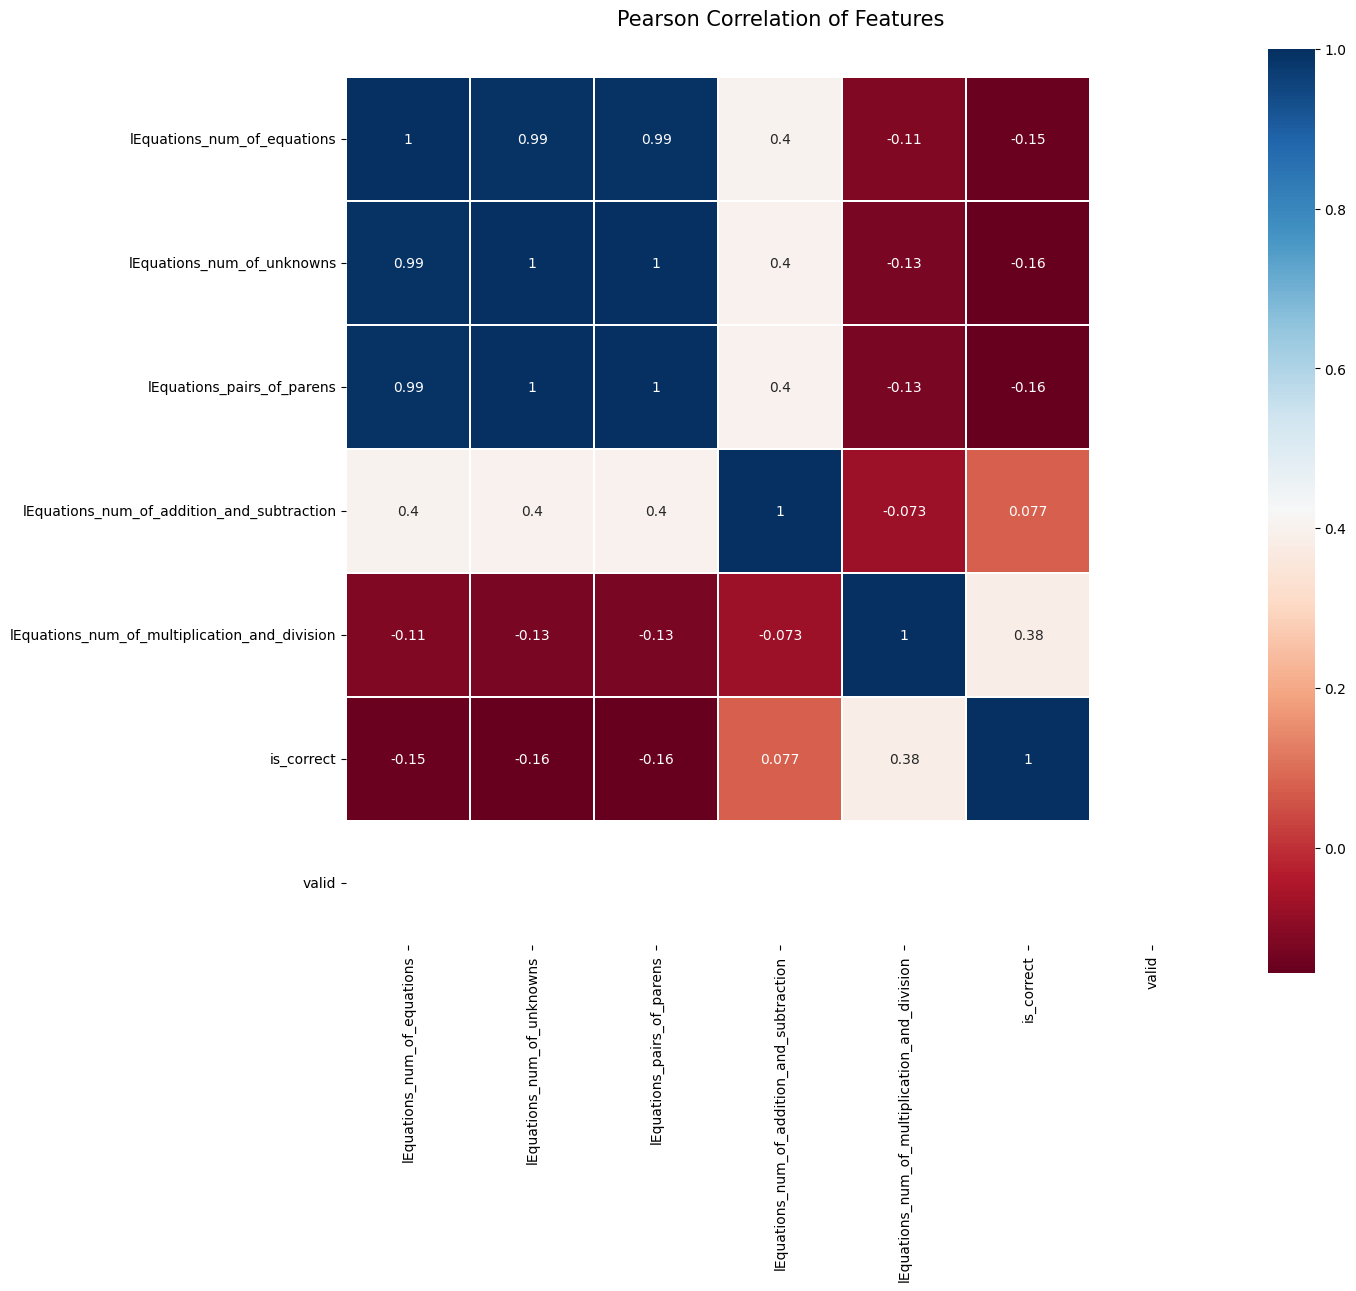

In [83]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

**Takeaways from heatmap**  
We observe from the Pearson heatmap that there are many features that strongly correlate with one another. As such, during, testing, it may be important to remove certain fields if the model is not performing well


In [84]:
del data

## Calculate causality values

In [85]:
def causality_values(input_file_path, output_file_path):
    # causality_values --
    # Calculates causality values

    # Load data
    data = pd.read_json(input_file_path)

    # Then remove all the non binary columns
    data = remove_non_binary_columns(data)

    # TODO: I'm not sure if there's another way to do this, so feel free to make modifications
    # Generate a dud data frame with a single so we can append to it.
    to_save = generate_row(data, VALID_COLUMN)
    for column in data.columns:
        if column in [VALID_COLUMN, EFFECT_COLUMN]:
            continue

        to_save = to_save.append(generate_row(data, column))

    # Remove the dud first row
    to_save = to_save[1:]
    display(to_save)
    to_save.to_json(output_file_path, orient='records')

    """"""
causality_values(COMBINED_FILE_PATH, CAUSALITY_FILE_PATH)

,name,support,causality,rel,conditional_probability,prior,conditional - prior
0,lEquations_num_of_equations_geq_1,1000,n/a,,0.487000,0.487,0.000000
0,lEquations_num_of_equations_geq_2,745,n/a,,0.441611,0.487,-0.045389
0,lEquations_num_of_equations_geq_3,1,-0.304578,lEquations_num_of_addition_and_subtraction_geq...,1.000000,0.487,0.513000
0,lEquations_num_of_equations_geq_4,0,n/a,,0.000000,0.487,-0.487000
0,lEquations_num_of_equations_geq_5,0,n/a,,0.000000,0.487,-0.487000
...,...,...,...,...,...,...,...
0,Template_num_of_unknowns_geq_6,349,-0.009129,"lEquations_num_of_equations_geq_3,lEquations_n...",0.578797,0.487,0.091797
0,Template_num_of_unknowns_geq_7,42,0.043762,lEquations_num_of_addition_and_subtraction_geq...,0.500000,0.487,0.013000
0,Template_num_of_unknowns_geq_8,22,n/a,,0.363636,0.487,-0.123364
0,Template_num_of_unknowns_geq_9,0,n/a,,0.000000,0.487,-0.487000


### Function to subsample the dataset by 50|50

In [86]:
def split_dataset(input_file_path, output_file_path):
    data = pd.read_json(input_file_path)

    correct_data = data[data[EFFECT_COLUMN] == 0]
    wrong_data = data[data[EFFECT_COLUMN] == 1]
    
    display(len(correct_data.index))
    display(len(wrong_data.index))
    shortest_len = min(len(correct_data.index), len(wrong_data.index))
    
    
    correct_data = correct_data.head(shortest_len)
    wrong_data = wrong_data.head(shortest_len)

    correct_data = correct_data.append(wrong_data)
    correct_data = shuffle(correct_data, random_state=SEED)

    display(len(correct_data.index))
    correct_data.to_json(output_file_path, orient='records')
split_dataset(COMBINED_FILE_PATH, SPLIT_DATASET_FILE_PATH)

513

487

974

## Gauging performance on various models (Scikit-Learn models, XGBoost)

In [87]:
def train_test_even_split(data, test_size):
    not_effect = data[data[EFFECT_COLUMN] == 0]
    effect = data[data[EFFECT_COLUMN] == 1]

    split_size = int((len(data.index) * test_size) / 2)

    test_not_effect = not_effect.head(split_size)
    test_effect     = effect.head(split_size)
    test            = pd.concat([test_not_effect, test_effect])

    train_not_effect = not_effect.tail(len(not_effect.index) - split_size)
    train_effect     = effect.tail(len(effect.index) - split_size)
    train           = pd.concat([train_not_effect, train_effect])
    train           = shuffle(train, random_state=SEED)

    display(len(test_not_effect.index),len(test_effect.index))
    display(len(train_not_effect.index),len(train_effect.index))

    return train, test



In [88]:
data = pd.read_json(CURR_FILE_PATH)

# Remove binary columns
data=remove_binary_columns(data)
data = data.drop(columns=["result", OTHER_COLUMN])
display(len(data.columns))

display(data.head(3))

train, test = train_test_split(data, test_size=0.2, random_state=SEED) 

ntrain = train.shape[0]
ntest = test.shape[0]

NFOLDS = 5

kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend Sklearn classifiers
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        self.clf = clf(**params, random_state=seed)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_


12

,lEquations_num_of_equations,lEquations_num_of_unknowns,lEquations_pairs_of_parens,lEquations_num_of_addition_and_subtraction,lEquations_num_of_multiplication_and_division,Template_num_of_equations,Template_num_of_unknowns,Template_pairs_of_parens,Template_num_of_addition_and_subtraction,Template_num_of_multiplication_and_division,is_correct,valid
0,1,1,1,2,2,1,4,4,2,4,0,1
1,2,2,2,2,2,2,6,6,2,2,0,1
2,1,1,1,1,4,1,4,4,1,4,0,1


Utility function to test out classifiers on kfolds

In [89]:
def get_performance(fold, y_predict, y_true):
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict).ravel()
    incorrect_precision = (tp / (tp + fp))
    incorrect_recall    = (tp / (tp + fn))
    correct_precision = (tn / (tn + fn))
    correct_recall    = (tn / (tn + fp))

    if (tp + fp) == 0: incorrect_precision = -1
    if (tp + fn) == 0: incorrect_recall = -1
    if (tn + fn) == 0: correct_precision = -1
    if (tn + fp) == 0: correct_recall = -1

    return {
        "fold"                                : fold,
        f"precision of predicting incorrect"  : incorrect_precision,
        f"recall of predicting incorrect"     : incorrect_recall,

        f"precision of predicting correct"    : correct_precision,
        f"recall of predicting correct"       : correct_recall,
        
        f"tn"                                 : tn,
        f"fp"                                 : fp,
        f"fn"                                 : fn,
        f"tp"                                 : tp,
    }

def get_average_in_object(object_array):
    obj_map = dict()
    cnt = 0
    for object in object_array:
        success = True
        for attr, value in object.items():
            if value == -1: 
                success = False
                continue
        if success: 
            for attr, value in object.items():
                if attr in obj_map: obj_map[attr] = (value + obj_map[attr] * cnt) / (cnt + 1)
                else: obj_map[attr] = value
            cnt += 1
            
    return obj_map

def get_oof(clf, x_train, y_train, output_file_path):
    current_fold = 1
    performance = []
    oof_train = np.array([])

    for train_index, test_index in kfold.split(x_train, y_train):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]
        y_te = y_train.iloc[test_index]

        clf.train(x_tr, y_tr)

        oof_train = np.append(oof_train, [clf.predict(x_te)])

        oof_test_skf = clf.predict(x_te)
        performance.append(get_performance(current_fold, oof_test_skf, y_te))

        current_fold += 1

    avg = get_average_in_object(performance)
    avg['fold'] = 'average'
    performance.append(avg)
    pd.DataFrame(performance).to_json(output_file_path, orient='records')
    return oof_train, oof_test_skf

Various parameters for our various models

In [90]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train[EFFECT_COLUMN]
x_train = train.drop([EFFECT_COLUMN], axis=1) # Creates an array of the train data

x_test = test.drop([EFFECT_COLUMN], axis=1) # Creats an array of the test data
y_test = test[EFFECT_COLUMN]

In [91]:
# Put in parameters for said classifiers
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0    # TRYING THINGS OUT
    , 'class_weight': 'balanced_subsample'
}

et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0    # TRYING THINGS OUT
    , 'class_weight': 'balanced'
}

ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75,
}

gb_params = {
    'n_estimators': 500,
    # 'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
}

svc_params = {
    'kernel': 'linear',
    'C': 0.025, 'class_weight': 'balanced'
}

logistic_regression_params = {

}

mlp_params = {
}

mlp_params_05_layers = {
    'hidden_layer_sizes': [100, 50, 25, 12, 6],
}


mlp_params_10_layers = {
    'hidden_layer_sizes': [100, 100, 50, 50, 25, 25, 12, 12, 6, 6]
}

mlp_params_20_layers = {
    'hidden_layer_sizes': [100,100,100,100,100,50,50,50,50,50,25,25,25,25,25,12,12,12,12,12]
}

mlp_params_30_layers = {
    'hidden_layer_sizes': [100,100,100,100,100,100,100,50,50,50,50,50,50,50,25,25,25,25,25,25,25,12,12,12,12,12,12,12,12, 12]
}

xgboost_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 2,
    'scale_pos_weight': negation(data[EFFECT_COLUMN]).sum() / data[EFFECT_COLUMN].sum()
}


In [92]:
# Create 5 objects that represent our 4 models
random_forest = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
extra_trees = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada_boost = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gradient_boost = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
logistic_regression = SklearnHelper(clf=LogisticRegression, seed=SEED, params=logistic_regression_params)
mlp = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params)
xgb = SklearnHelper(clf=XGBClassifier, seed=SEED, params=xgboost_params)

weight_0, loss_function_05, weight_10, loss_function_10, weight_20, loss_function_20, weight_30, loss_function_30, pytorch_mlp_05, pytorch_mlp_10, pytorch_mlp_20, pytorch_mlp_30 = None, None, None, None, None, None, None, None, None, None, None, None

# Base
loss_function_05 = nn.CrossEntropyLoss()
loss_function_10 = nn.CrossEntropyLoss()
loss_function_20 = nn.CrossEntropyLoss()
loss_function_30 = nn.CrossEntropyLoss()

pytorch_mlp_05 = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params_05_layers)
pytorch_mlp_10 = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params_10_layers)
pytorch_mlp_20 = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params_20_layers)
pytorch_mlp_30 = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params_30_layers)

In [93]:

if os.path.exists(OOF_FILE_PATH):
        shutil.rmtree(OOF_FILE_PATH)
os.makedirs(OOF_FILE_PATH)

# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test       = get_oof(extra_trees, x_train, y_train, f"{OOF_FILE_PATH}/extra_trees.json") # Extra Trees
rf_oof_train, rf_oof_test       = get_oof(random_forest, x_train, y_train, f"{OOF_FILE_PATH}/random_forest.json") # Random Forest
ada_oof_train, ada_oof_test     = get_oof(ada_boost, x_train, y_train, f"{OOF_FILE_PATH}/ada_boost.json") # Adaboost
gb_oof_train, gb_oof_test       = get_oof(gradient_boost, x_train, y_train, f"{OOF_FILE_PATH}/gradient_boost.json") # Gradient boost
svc_oof_train, svc_oof_test     = get_oof(svc, x_train, y_train, f"{OOF_FILE_PATH}/svc.json") # SVC
logistic_regression_oof_train, logistic_regression_oof_test = get_oof(logistic_regression, x_train, y_train, f"{OOF_FILE_PATH}/logistic_regression.json") # Logistic regression
mlp_oof_train, mlp_oof_test     = get_oof(mlp, x_train, y_train, f"{OOF_FILE_PATH}/mlp.json") # MLP
xgb_oof_train, xgb_oof_test     = get_oof(xgb, x_train, y_train, f"{OOF_FILE_PATH}/xgb.json") # XGBoost

pytorch_mlp_05_train, pytorch_mlp_05_test         = get_oof(pytorch_mlp_05, x_train, y_train, f"{OOF_FILE_PATH}/pytorch_mlp_5.json") # MLP
pytorch_mlp_10_train, pytorch_mlp_10_test         = get_oof(pytorch_mlp_10, x_train, y_train, f"{OOF_FILE_PATH}/pytorch_mlp_10.json") # MLP
pytorch_mlp_20_train, pytorch_mlp_20_test       = get_oof(pytorch_mlp_20, x_train, y_train, f"{OOF_FILE_PATH}/pytorch_mlp_20.json") # MLP
pytorch_mlp_30_train, pytorch_mlp_30_test       = get_oof(pytorch_mlp_30, x_train, y_train, f"{OOF_FILE_PATH}/pytorch_mlp_30.json") # MLP
print("Models trained")

Models trained


In [94]:
extra_trees_features       = extra_trees.feature_importances(x_train, y_train)
random_forest_features       = random_forest.feature_importances(x_train, y_train)
ada_boost_features       = ada_boost.feature_importances(x_train, y_train)
gradient_boost_features       = gradient_boost.feature_importances(x_train, y_train)

In [95]:
cols = x_train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': random_forest_features,
     'Extra Trees  feature importances': extra_trees_features,
      'AdaBoost feature importances': ada_boost_features,
    'Gradient Boost feature importances': gradient_boost_features
    })

We now convert every json file to xlsx

In [96]:
def convert_to_xlsx(EXTRA):

    if os.path.exists(f"{XLSX_OUTPUT_FILE_PATH}{EXTRA}"):
        shutil.rmtree(f"{XLSX_OUTPUT_FILE_PATH}{EXTRA}")
    os.makedirs(f"{XLSX_OUTPUT_FILE_PATH}{EXTRA}")

    for directory in os.listdir(f"{JSON_OUTPUT_FILE_PATH}{EXTRA}"):
        json_file_path = f"{JSON_OUTPUT_FILE_PATH}{EXTRA}{directory}"

        if os.path.isdir(json_file_path): 
            convert_to_xlsx(f"{EXTRA}{directory}/")
            continue

        data = pd.read_json(json_file_path)
        data.to_excel(f"{XLSX_OUTPUT_FILE_PATH}{EXTRA}{os.path.splitext(directory)[0]}.xlsx")

convert_to_xlsx("")

In [97]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')